In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
from pytorch_transformers import modeling_bert
import numpy as np
import torch
from pytorch_transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
from tqdm import tqdm
import pdb
import torch.nn.functional as F
from torch import optim
import sys
model_name = 'complete_PU_Bert'
import time
import imp
import utils
#from utils import batch_sent_loader
import os
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import metrics
imp.reload(utils)
hpara1 = utils.hpara()

In [3]:
training_generator,validation_generator,dummy_generator = utils.load_data(ratio =10,clarity=True,stratify=True)
tokenizer = utils._load_tf_tokenizer(vocab_file = '/gpfs/qlong/home/tzzhang/nlp_test/bert/mimic_based_models/vocab.txt')

In [4]:
model_state_dict = "/gpfs/qlong/home/tzzhang/bioBert/pretrained_bert_tf/biobert_pretrain_output_all_notes_150000/pytorch_model.bin"
config = modeling_bert.BertConfig.from_pretrained('bert-base-uncased')
config.vocab_size = 28996
config.num_hidden_layers =6
model_word = modeling_bert.BertModel(config)

In [5]:
config_doc = modeling_bert.BertConfig.from_pretrained('bert-base-uncased')
config_doc.num_hidden_layers =3
model_sent = modeling_bert.BertModel_no_embedding(config_doc)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [6]:
config_doc = modeling_bert.BertConfig.from_json_file(bert_config_file)
config_doc.num_hidden_layers =3
model_sent = modeling_bert.BertModel_no_embedding(config_doc)

NameError: name 'bert_config_file' is not defined

In [4]:
tf_src_dir = '/gpfs/qlong/home/tzzhang/nlp_test/bert/mimic_based_complete_model'
bert_config_file = os.path.join(tf_src_dir,'bert_config.json')
config = modeling_bert.BertConfig.from_json_file(bert_config_file)
config.num_hidden_layers =6
config.output_attentions = True
model_word = modeling_bert.BertModel(config)

In [5]:
config

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "num_labels": 2,
  "output_attentions": true,
  "output_hidden_states": false,
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 29224
}

In [6]:
config_doc = modeling_bert.BertConfig.from_json_file(bert_config_file)
config_doc.num_hidden_layers =3
config_doc.output_attentions = True
model_sent = modeling_bert.BertModel_no_embedding(config_doc,use_advanced_loss=True)

In [7]:
para = model_word.state_dict()
att_layer_weight = para['encoder.layer.0.attention.self.query.weight']
print(att_layer_weight[0,:10])

tensor([ 0.0088, -0.0361,  0.0033, -0.0155,  0.0115,  0.0071, -0.0358, -0.0025,
         0.0053,  0.0209])


In [9]:
exp_dir = './exp/Complete_PU_Bert_2019_11_19_angular/'
model_word.load_state_dict(torch.load(exp_dir + 'save_word_15.bin'))
model_sent.load_state_dict(torch.load(exp_dir + 'save_sent_15.bin'))

RuntimeError: Error(s) in loading state_dict for BertModel_no_embedding:
	Missing key(s) in state_dict: "embeddings.position_embeddings.weight", "embeddings.token_type_embeddings.weight", "embeddings.LayerNorm.weight", "embeddings.LayerNorm.bias". 

In [8]:
para = model_word.state_dict()
att_layer_weight = para['encoder.layer.0.attention.self.query.weight']
print(att_layer_weight[0,:10])

tensor([ 0.0088, -0.0361,  0.0033, -0.0155,  0.0115,  0.0071, -0.0358, -0.0025,
         0.0053,  0.0209])


In [9]:
model_sent

BertModel_no_embedding(
  (embeddings): BertEmbeddings_no_word(
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1)
          )
        )
        (intermediate): BertIntermediate

In [10]:
date = str(list(time.localtime())[0:3]).replace(', ','_')
save_dir = './exp/'+model_name+'_'+date[1:-1]+'_eval_10ratio/'
if not os.path.exists(save_dir):
    cmd = 'mkdir -p ' + save_dir
    os.system(cmd)

In [11]:
import imp
from sklearn.metrics import confusion_matrix
imp.reload(utils)

do_train = True
do_test = True
criterion = torch.nn.NLLLoss()
log_file = open(save_dir+'log','a')
optimizer = optim.Adamax
word_optimizer = optimizer(model_word.parameters(), lr=0.00005)
sent_optimizer = optimizer(model_sent.parameters(), lr=0.0003)
max_epoch = 20
log = 'Iter {}/{}, Loss={:.3f},accu={:.3f},time={:.3f}\n'
from tqdm import tqdm
batch_size = 1
accumulation_steps = 10
max_sent_len = 64
max_doc_len = 400
cls_weight = torch.tensor(np.load('cls_weight.npy')).cuda()
sep_weight = torch.tensor(np.load('sep_weight.npy')).cuda()

In [16]:
cls_weight[:10]

tensor([ 0.0103, -0.0027, -0.0020,  0.0270, -0.0065,  0.0016,  0.0928, -0.0734,
        -0.0042,  0.0053], device='cuda:0')

In [17]:
sep_weight[:10]

tensor([-0.0010, -0.0002,  0.0179, -0.0179, -0.0112, -0.0063,  0.0103, -0.0313,
         0.0174, -0.0204], device='cuda:0')

In [13]:
model_word = model_word.cuda()
model_sent = model_sent.cuda()

In [14]:
save_dir

'./exp/complete_PU_Bert_2019_11_25_eval_10ratio/'

In [18]:
start = time.time()
model_sent.eval()
model_word.eval()
pred_list = []
y_list = []
y_hat = []

correct = sum_loss =total_num = 0
for doc_count,(doc,label) in enumerate(validation_generator):
    total_num += len(label)
    #doc, label = Variable(doc).to(device), Variable(label).to(device)#数据和标签
    label = label.cuda()
    batch_count=0
    sent_num = 0
    #print(len(doc))
    input_tensors = torch.zeros([1,max_doc_len,config.hidden_size]).cuda()
    # Add cls in sent level
    input_tensors[0,0] = cls_weight
    while batch_size * batch_count < len(doc) and batch_size * batch_count < max_doc_len:
        batch_sent =utils.batch_sent_loader(doc,batch_size,batch_count,max_doc_len=max_doc_len)
        cur_batch_size = len(batch_sent)
        sent_num += cur_batch_size
        input_ids = torch.zeros(cur_batch_size,max_sent_len).long().cuda()
        input_mask = torch.ones(cur_batch_size,max_sent_len).long().cuda()
        for i in range(len(batch_sent)):
            tmp_ids,tmp_mask= utils.word_tokenize(batch_sent[i][0],max_sent_len,tokenizer)
            input_ids[i,:] = torch.tensor(tmp_ids)
            input_mask[i,:] = torch.tensor(tmp_mask)
        _,tmp_input_tensors,_ = model_word(input_ids,attention_mask=input_mask)
        #pdb.set_trace()
        start_ind = batch_count*batch_size+1
        end_ind = start_ind + cur_batch_size
        input_tensors[0,start_ind:end_ind] = tmp_input_tensors
        batch_count +=1

    # -----------Add sep in sent matrix----------
    if end_ind<max_doc_len:
        input_tensors[0,end_ind] = sep_weight
    else:
        end_ind = max_doc_len-1
        input_tensors[0,end_ind] = sep_weight
        
    sent_mask = [1]*(end_ind+1)
    while len(sent_mask)<max_doc_len:
        sent_mask.append(0)
    sent_mask = torch.tensor(sent_mask).unsqueeze(0).cuda()
    loss,proba,att_output = model_sent(input_tensors,label,attention_mask=sent_mask)
    
    pos_socre = np.exp(proba.cpu().detach().numpy())[0,1]
    y_hat.append(pos_socre)
    _,predicted = torch.max(proba,1)
    #for making confusion matrix
    pred_list.append(predicted.item())
    if predicted.item():
        pdb.set_trace()
    y_list.append(label.item())
    sum_loss += loss.item() * len(label)
    #print(logits)
    correct += (predicted == label).sum()
accu = correct.item() / total_num
to_print=log.format(0,0,sum_loss,accu,time.time() - start)
to_print = 'Test ' + to_print
print(to_print)
print(confusion_matrix(y_list,pred_list))

> <ipython-input-18-f8b967feb4fe>(56)<module>()
-> y_list.append(label.item())
(Pdb) input_tensors[0,:10]
tensor([[ 0.0103, -0.0027, -0.0020,  ..., -0.0044, -0.0107, -0.0189],
        [ 0.1964, -0.4996, -0.2333,  ...,  0.2441,  0.5689, -0.8298],
        [ 0.1690, -0.6335, -0.3122,  ...,  0.4640,  0.4295, -0.8421],
        ...,
        [ 0.1680, -0.6038, -0.3888,  ...,  0.4722,  0.5481, -0.8317],
        [ 0.2293, -0.6865, -0.3041,  ...,  0.4282,  0.5878, -0.8721],
        [ 0.2511, -0.6399, -0.3429,  ...,  0.4716,  0.6130, -0.8510]],
       device='cuda:0', grad_fn=<SliceBackward>)
(Pdb) input_tensors[0,0,:10]
tensor([ 0.0103, -0.0027, -0.0020,  0.0270, -0.0065,  0.0016,  0.0928, -0.0734,
        -0.0042,  0.0053], device='cuda:0', grad_fn=<SliceBackward>)
(Pdb) input_tensors[0,1,:10]
tensor([ 0.1964, -0.4996, -0.2333, -0.5556, -0.3577,  0.0446,  0.8414, -0.2477,
         0.4182, -0.4669], device='cuda:0', grad_fn=<SliceBackward>)
(Pdb) input_tensors[0,end_ind,:10]
tensor([-0.0010, -0.

BdbQuit: 

In [13]:
cls_weight = para['embeddings.word_embeddings.weight'][101].numpy()

In [13]:
np.save('cls_weight.npy',cls_weight)

In [14]:
sep_weight = para['embeddings.word_embeddings.weight'][102].numpy()
np.save('sep_weight.npy',sep_weight)

In [16]:
input_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')

In [17]:
np.shape(input_tensors)

torch.Size([1, 400, 768])

In [18]:
input_tensors.size(1)

400

In [21]:
att_output2[0].shape[2]

400

In [20]:
att_output2 = att_output[0]

In [25]:
len(att_output2)

3

In [25]:
one_layer_att_heads = att_output[0][0]

In [22]:
from scipy.special import softmax
def radical_back_trace(att_heads):
    seq_len = att_heads[0].shape[2]
    layer_num = len(att_heads)
    last_layer_portion = np.diag([1] * seq_len)
    for layer in range(layer_num):
        curr_layer_portion = np.zeros([seq_len,seq_len])
        one_layer_att_heads = att_heads[layer][0]
        sum_through_heads = torch.sum(one_layer_att_heads,0)
        sum_through_heads = sum_through_heads.cpu().detach().numpy()
        sum_through_heads = np.where(sum_through_heads > 0.001, sum_through_heads, sum_through_heads -1000)
        #pdb.set_trace()
        #prop_through_heads = sum_through_heads
        prop_through_heads = softmax(sum_through_heads,axis=1)
        curr_layer_portion = np.matmul(prop_through_heads, last_layer_portion)
        last_layer_portion = curr_layer_portion    
    return curr_layer_portion

In [23]:
from_stupid = radical_back_trace(att_output[0])

In [29]:
from_stupid

array([[0.00061771, 0.00062049, 0.0006255 , ..., 0.        , 0.        ,
        0.        ],
       [0.00061771, 0.00062049, 0.0006255 , ..., 0.        , 0.        ,
        0.        ],
       [0.00061771, 0.00062049, 0.0006255 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00540821, 0.00543258, 0.00547644, ..., 0.        , 0.        ,
        0.        ],
       [0.00097779, 0.0009822 , 0.00099013, ..., 0.        , 0.        ,
        0.        ],
       [0.00061771, 0.00062049, 0.0006255 , ..., 0.        , 0.        ,
        0.        ]])

In [26]:
from_smart = radical_back_trace(att_output[0])

In [27]:
np.shape(from_smart)

(400, 400)

In [28]:
for i in range(400):
    print(np.max(from_smart[i,:]))

0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.016716480631953582
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.9050189021728761
0.90501890

In [42]:
np.shape(from_stupid)

(64, 64)

In [44]:
from_stupid

array([[0.40096774, 0.0231185 , 0.02262848, ..., 0.        , 0.        ,
        0.        ],
       [0.4015151 , 0.02308963, 0.0225985 , ..., 0.        , 0.        ,
        0.        ],
       [0.4014988 , 0.02309052, 0.02259941, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.40134325, 0.0230987 , 0.02260791, ..., 0.        , 0.        ,
        0.        ],
       [0.40122026, 0.0231052 , 0.02261466, ..., 0.        , 0.        ,
        0.        ],
       [0.40087758, 0.02312324, 0.02263339, ..., 0.        , 0.        ,
        0.        ]])

In [25]:
from_stupid[0,:]

array([0.86644577, 0.00461578, 0.00860582, 0.00421388, 0.0266807 ,
       0.00151589, 0.00151589, 0.00151589, 0.00151589, 0.00151589,
       0.00151589, 0.00151589, 0.00151589, 0.00151589, 0.00151589,
       0.00151589, 0.00151589, 0.00151589, 0.00151589, 0.00151589,
       0.00151589, 0.00151589, 0.00151589, 0.00151589, 0.00151589,
       0.00151589, 0.00151589, 0.00151589, 0.00151589, 0.00151589,
       0.00151589, 0.00151589, 0.00151589, 0.00151589, 0.00151589,
       0.00151589, 0.00151589, 0.00151589, 0.00151589, 0.00151589,
       0.00151589, 0.00151589, 0.00151589, 0.00151589, 0.00151589,
       0.00151589, 0.00151589, 0.00151589, 0.00151589, 0.00151589,
       0.00151589, 0.00151589, 0.00151589, 0.00151589, 0.00151589,
       0.00151589, 0.00151589, 0.00151589, 0.00151589, 0.00151589,
       0.00151589, 0.00151589, 0.00151589, 0.00151589])

In [26]:
from_stupid[1,:]

array([0.86644911, 0.00461555, 0.00860507, 0.00421367, 0.02668044,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587])

In [28]:
from_stupid[2,:]

array([0.86644851, 0.00461557, 0.00860512, 0.00421369, 0.02668044,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587, 0.00151587,
       0.00151587, 0.00151587, 0.00151587, 0.00151587])

In [27]:
batch_sent

[('Admission Date:',)]

In [28]:
layer = 1 
att_heads = att_output
one_layer_att_heads = att_heads[layer]

In [78]:
one_layer_att_heads.shape

torch.Size([1, 12, 64, 64])

In [47]:
seq_len = 5
np.diag([1] * seq_len)
tmp_sum = np.zeros(seq_len)

In [48]:
tmp_sum

array([0., 0., 0., 0., 0.])

In [26]:
one_layer_att_heads.shape

torch.Size([12, 64, 64])

In [32]:
aaa = torch.sum(one_layer_att_heads,0)
aaa.shape

torch.Size([64, 64])

In [27]:
aaa = model_word(input_ids,attention_mask=input_mask)

In [40]:
aaa = torch.sum(one_layer_att_heads,0)
aaa = aaa.cpu().detach().numpy()
bbb = softmax(aaa,axis=1)

In [41]:
np.sum(bbb)

64.0

In [43]:
np.shape(bbb)

(64, 64)

In [29]:
print(type(aaa))
print(len(aaa))

<class 'tuple'>
2


In [24]:
 np.shape(tmp_input_tensors)

torch.Size([6, 768])

In [17]:
import sklearn
sklearn.metrics.f1_score(y_list,pred_list)

0.8040973111395646

In [23]:
fpr,tpr,thres = roc_curve(y_list,y_hat)
save_dir = '/gpfs/qlong/home/tzzhang/mimicIII/nn_code/exp/'
np.save(os.path.join(save_dir,'fpr.npy'),fpr)
np.save(os.path.join(save_dir,'tpr.npy'),tpr)
np.save(os.path.join(save_dir,'thres.npy'),thres)

In [ ]:
fpr,tpr,thres = roc_curve(y_list,y_hat)
np.save(os.path.join(save_dir,'fpr.npy'),fpr)
np.save(os.path.join(save_dir,'tpr.npy'),tpr)
np.save(os.path.join(save_dir,'thres.npy'),thres)

0.9346480649586207

In [1]:
to_print=log.format(0,0,sum_loss,accu,time.time() - start)
to_print = 'Test ' + to_print
print(to_print)
print(confusion_matrix(y_list,pred_list))

NameError: name 'log' is not defined

In [27]:
aaa = input_tensors[0,batch_count*batch_size:batch_count*batch_size+cur_batch_size]
aaa.shape

torch.Size([74, 768])

In [26]:
batch_count

0

In [ ]:
accu = correct.item() / total_num
to_print=log.format(0,max_epoch,sum_loss,accu,time.time() - start)
to_print = 'Test ' + to_print
print(to_print)
print(confusion_matrix(y_list,pred_list))
log_file.writelines(to_print)
log_file.close()

In [14]:
Test Iter 0/20, Loss=447.199,accu=0.820,time=311.612

[[745  52]
 [161 225]]

382

In [22]:
proba

tensor([[-0.5129, -0.9131]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [25]:
proba2= proba.cpu().detach().numpy()

In [26]:
proba2

array([[-0.5129397, -0.9131278]], dtype=float32)

In [27]:
np.exp(proba2)

array([[0.5987329 , 0.40126717]], dtype=float32)

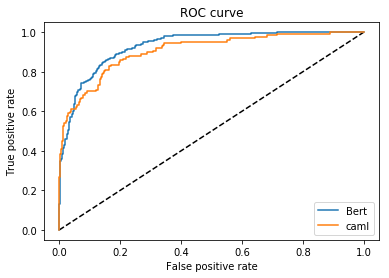

In [24]:
#fpr,tpr,thres = roc_curve(y_list,y_hat)
fpr_caml = np.load('/gpfs/qlong/home/tzzhang/mimicIII/nn_code/exp/caml/fpr.npy')
tpr_caml = np.load('/gpfs/qlong/home/tzzhang/mimicIII/nn_code/exp/caml/tpr.npy')

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Bert')
plt.plot(fpr_caml, tpr_caml, label='caml')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

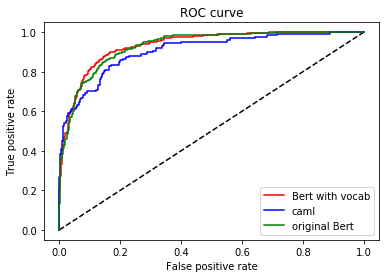

In [16]:
fpr_ori = np.load('/gpfs/qlong/home/tzzhang/mimicIII/nn_code/exp/Best_Clinical_Bert/fpr.npy')
tpr_ori = np.load('/gpfs/qlong/home/tzzhang/mimicIII/nn_code/exp/Best_Clinical_Bert/tpr.npy')

fpr_caml = np.load('/gpfs/qlong/home/tzzhang/mimicIII/nn_code/exp/caml/fpr.npy')
tpr_caml = np.load('/gpfs/qlong/home/tzzhang/mimicIII/nn_code/exp/caml/tpr.npy')

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Bert with vocab',color='r')
plt.plot(fpr_caml, tpr_caml, label='caml',color='b')
plt.plot(fpr_ori, tpr_ori, label='original Bert',color='g')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [11]:
imp.reload(utils)

start = time.time()
model_sent.eval()
model_word.eval()
pred_list = []
y_list = []
correct = sum_loss =total_num = 0
y_hat = []
model_word = model_word.cuda()
model_sent = model_sent.cuda()
for doc_count,(doc,label) in enumerate(validation_generator):
    total_num += len(label)
    #doc, label = Variable(doc).to(device), Variable(label).to(device)#数据和标签
    label = label.cuda()
    batch_count=0
    sent_num=0
    #print(len(doc))
    input_tensors = torch.zeros([1,max_doc_len,config.hidden_size]).cuda()
    while batch_size * batch_count < len(doc) and batch_size * (batch_count+1) < max_doc_len:
        batch_sent =utils.batch_sent_loader(doc,batch_size,batch_count,max_doc_len=max_doc_len)
        cur_batch_size = len(batch_sent)
        sent_num += cur_batch_size
        input_ids = torch.zeros(cur_batch_size,max_sent_len).long().cuda()
        input_mask = torch.ones(cur_batch_size,max_sent_len).long().cuda()
        for i in range(len(batch_sent)):
            tmp_ids,tmp_mask= utils.word_tokenize(batch_sent[i][0],max_sent_len,tokenizer)
            input_ids[i,:] = torch.tensor(tmp_ids)
            input_mask[i,:] = torch.tensor(tmp_mask)
        _,tmp_input_tensors = model_word(input_ids,attention_mask=input_mask)
        start_ind = batch_count*batch_size
        end_ind = start_ind + cur_batch_size
        input_tensors[0,start_ind:end_ind] = tmp_input_tensors
        batch_count +=1
    sent_mask = [1]*sent_num
    while len(sent_mask)<max_doc_len:
        sent_mask.append(0)
    sent_mask = torch.tensor(sent_mask).unsqueeze(0).cuda()
    _,proba = model_sent(input_tensors,label,attention_mask=sent_mask)
    pos_socre = np.exp(proba.cpu().detach().numpy())[0,1]
    y_hat.append(pos_socre)
    loss = criterion(proba, label)
    _,predicted = torch.max(proba,1)
    #for making confusion matrix
    pred_list.append(predicted.item())
    y_list.append(label.item())

    sum_loss += loss.item() * len(label)
    #print(logits)
    correct += (predicted == label).sum()
fpr,tpr,thres = roc_curve(y_list,y_hat)
np.save(os.path.join(save_dir,'fpr.npy'),fpr)
np.save(os.path.join(save_dir,'tpr.npy'),tpr)
np.save(os.path.join(save_dir,'thres.npy'),thres)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



# New 11-15

In [3]:
hpara1 = utils.hpara()
hpara1.ratio = 10

In [4]:
# Set up the word embedding model but do not load the pre-trained parameters
tf_src_dir = '/gpfs/qlong/home/tzzhang/nlp_test/bert/mimic_based_complete_model'
bert_config_file = os.path.join(tf_src_dir,'bert_config.json')
config = modeling_bert.BertConfig.from_json_file(bert_config_file)
config.num_hidden_layers = hpara1.word_layers
model_word = modeling_bert.BertModel(config)

In [5]:
imp.reload(utils)
training_generator,validation_generator,dummy_generator = utils.load_data(ratio=hpara1.ratio,clarity=True,stratify =True)
tokenizer = utils._load_tf_tokenizer(vocab_file = '/gpfs/qlong/home/tzzhang/nlp_test/bert/mimic_based_complete_model/vocab.txt')

In [6]:
para = model_word.state_dict()
att_layer_weight = para['encoder.layer.0.attention.self.query.weight']
print(att_layer_weight[0,:10])

tensor([-0.0284, -0.0251,  0.0168, -0.0085, -0.0121, -0.0086,  0.0285,  0.0362,
         0.0117, -0.0014])


In [7]:
config_doc = modeling_bert.BertConfig.from_json_file(bert_config_file)
config_doc.num_hidden_layers = hpara1.sent_layers
model_sent = modeling_bert.BertModel_no_embedding(config_doc)

In [8]:
para = model_word.state_dict()
att_layer_weight = para['encoder.layer.0.attention.self.query.weight']
print(att_layer_weight[0,:10])

tensor([-0.0284, -0.0251,  0.0168, -0.0085, -0.0121, -0.0086,  0.0285,  0.0362,
         0.0117, -0.0014])


In [15]:
exp_dir = './exp/PU_Bert_2019_11_18_complete_10ratio_weighted/'
model_word.load_state_dict(torch.load(exp_dir + 'save_word_3.bin'))
model_sent.load_state_dict(torch.load(exp_dir + 'save_sent_3.bin'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [16]:
model_word = model_word.cuda()
model_sent = model_sent.cuda()

In [17]:
import imp
from sklearn.metrics import confusion_matrix
imp.reload(utils)
date = str(list(time.localtime())[0:3]).replace(', ','_')
save_dir = './exp/'+model_name+'_'+date[1:-1]+'_eval_10ratio/'
if not os.path.exists(save_dir):
    cmd = 'mkdir -p ' + save_dir
    os.system(cmd)
do_train = True
do_test = True
criterion = torch.nn.NLLLoss()
log_file = open(save_dir+'log','a')
optimizer = optim.Adamax
word_optimizer = optimizer(model_word.parameters(), lr=0.00005)
sent_optimizer = optimizer(model_sent.parameters(), lr=0.0003)
max_epoch = 20
log = 'Iter {}/{}, Loss={:.3f},accu={:.3f},time={:.3f}\n'
from tqdm import tqdm
batch_size = 8
accumulation_steps = 10
max_sent_len = 64
max_doc_len = 400

In [18]:
start = time.time()
model_sent.eval()
model_word.eval()
pred_list = []
y_list = []
y_hat = []

correct = sum_loss =total_num = 0
for doc_count,(doc,label) in enumerate(validation_generator):
    total_num += len(label)
    #doc, label = Variable(doc).to(device), Variable(label).to(device)#数据和标签
    label = label.cuda()
    batch_count=0
    sent_num = 0
    #print(len(doc))
    input_tensors = torch.zeros([1,max_doc_len,config.hidden_size]).cuda()
    while batch_size * batch_count < len(doc) and batch_size * batch_count < max_doc_len:
        batch_sent =utils.batch_sent_loader(doc,batch_size,batch_count,max_doc_len=max_doc_len)
        cur_batch_size = len(batch_sent)
        sent_num += cur_batch_size
        input_ids = torch.zeros(cur_batch_size,max_sent_len).long().cuda()
        input_mask = torch.ones(cur_batch_size,max_sent_len).long().cuda()
        for i in range(len(batch_sent)):
            tmp_ids,tmp_mask= utils.word_tokenize(batch_sent[i][0],max_sent_len,tokenizer)
            input_ids[i,:] = torch.tensor(tmp_ids)
            input_mask[i,:] = torch.tensor(tmp_mask)
        _,tmp_input_tensors = model_word(input_ids,attention_mask=input_mask)
        start_ind = batch_count*batch_size
        end_ind = start_ind + cur_batch_size
        input_tensors[0,start_ind:end_ind] = tmp_input_tensors
        batch_count +=1
    sent_mask = [1]*sent_num
    while len(sent_mask)<max_doc_len:
        sent_mask.append(0)
    sent_mask = torch.tensor(sent_mask).unsqueeze(0).cuda()
    loss,proba = model_sent(input_tensors,label,attention_mask=sent_mask)
    pos_socre = np.exp(proba.cpu().detach().numpy())[0,1]
    y_hat.append(pos_socre)
    _,predicted = torch.max(proba,1)
    #for making confusion matrix
    pred_list.append(predicted.item())
    y_list.append(label.item())
    sum_loss += loss.item() * len(label)
    #print(logits)
    correct += (predicted == label).sum()
accu = correct.item() / total_num
to_print=log.format(0,0,sum_loss,accu,time.time() - start)
to_print = 'Test ' + to_print
print(to_print)
print(confusion_matrix(y_list,pred_list))

Test Iter 0/0, Loss=1041.482,accu=0.938,time=1218.466

[[3894   49]
 [ 218  176]]


In [ ]:
sklearn.metrics.roc_auc_score(y_list, y_hat)

In [19]:
fpr,tpr,thres = roc_curve(y_list,y_hat)
np.save(os.path.join(save_dir,'fpr.npy'),fpr)
np.save(os.path.join(save_dir,'tpr.npy'),tpr)
np.save(os.path.join(save_dir,'thres.npy'),thres)

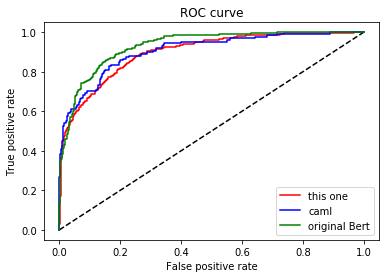

In [20]:
fpr_ori = np.load('/gpfs/qlong/home/tzzhang/mimicIII/nn_code/exp/Best_Clinical_Bert/fpr.npy')
tpr_ori = np.load('/gpfs/qlong/home/tzzhang/mimicIII/nn_code/exp/Best_Clinical_Bert/tpr.npy')

fpr_caml = np.load('/gpfs/qlong/home/tzzhang/mimicIII/nn_code/exp/caml/fpr.npy')
tpr_caml = np.load('/gpfs/qlong/home/tzzhang/mimicIII/nn_code/exp/caml/tpr.npy')

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='this one',color='r')
plt.plot(fpr_caml, tpr_caml, label='caml',color='b')
plt.plot(fpr_ori, tpr_ori, label='original Bert',color='g')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()